# NLP individual 
## Parsa Yaghoobi (URN: 6596381)
## Group 16

# All imports, installs, and functions required

In [142]:
from IPython.display import clear_output 
!pip install tensorflow
!pip install datasets
!pip install transformers
import numpy as np 
import pandas as pd 
import os
import re
import torch
from tqdm import tqdm
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from datasets import load_dataset
from collections import Counter
from transformers import (AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer)
from collections import Counter
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from tqdm.notebook import tqdm
from pathlib import Path
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
import re
from torch.utils.data import DataLoader
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()
stemmer = PorterStemmer()
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import GRU, Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from transformers import AutoTokenizer, TFAutoModel, TFAutoModelForSeq2SeqLM, AutoTokenizer, TFAutoModelForSequenceClassification
from transformers import DebertaTokenizer
from transformers.tokenization_utils_fast import PreTrainedTokenizerFast
from sklearn.metrics import classification_report


clear_output()

In [143]:
# check for GPU availability
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'\nThere are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")


There are 2 GPU(s) available.
Device name: Tesla T4


## All necessary functions that will be used 

In [144]:
def fourteen_labels(x, multi = False): # cuts down to 14 unique labels
    
    if multi == False:
        x = x[0]
    if x == 2 or x == 10 or x == 11:
        return 3
    elif x == 15 or x == 18 or x == 4 or x == 21:
        return 0
    elif x == 16 or x == 9 or x == 24 or x == 12:
        return 25
    elif x == 13 or x == 17:
        return 1
    elif x == 19:
        return 14
    else:
        return x

In [145]:
def new_labels(x, multi = False): # updates labels to be between 0-13

    if multi == False:
        x = x[0]
    if x == 0:
        return 0
    elif x == 1:
        return 1
    elif x == 3:
        return 2
    elif x == 5:
        return 3
    elif x == 6:
        return 4
    elif x == 7:
        return 5
    elif x == 8:
        return 6
    elif x == 14:
        return 7
    elif x == 20:
        return 8
    elif x == 22:
        return 9
    elif x == 23:
        return 10
    elif x == 25:
        return 11
    elif x == 26:
        return 12
    elif x == 27:
        return 13

In [146]:
def replace_labels(labels): # runs through a list of labels and uses the previous two functions to update them
    for i in tqdm(range(len(labels))):
        if len(labels[i]) == 1:
            labels[i] = [fourteen_labels(labels[i])]
            labels[i] = [new_labels(labels[i])]
        
        else:
            for j in range(len(labels[i])):
                labels[i][j] = fourteen_labels(labels[i][j], multi = True)
                labels[i][j] = new_labels(labels[i][j], multi = True)
    
    return labels

In [147]:
def remove_dupes(data): # stops a data point from having the same class label more than once
    z = []
    for x in data:
        z.append(list(dict.fromkeys(x)))
    return z

In [148]:
def one_hot_encoder(df): # converts labels of a single data point to their one-hot-encoded format
    one_hot_encoding = []
    for i in tqdm(range(len(df))):
        temp = [0] * n_labels
        label_indices = df.iloc[i]["labels"]
        for index in label_indices:
            temp[index] = 1
        one_hot_encoding.append(temp)
        
    return pd.DataFrame(one_hot_encoding)

In [149]:
def class_freq(data):
    class_freq = {} # create a dictionary of class frequencies for visualisation purposes
    classes = list(range(0,14))
    for x in classes:
        class_freq[x] = 0
    for x in data['labels']:
        if len(x) == 1:
            class_freq[x[0]] +=1
    else:
        for j in x:
            class_freq[j] +=1
    return class_freq

In [150]:
def multilabel2multiclass(ls):
    for i in range(len(ls)):
        if len(ls[i]) > 1:
            temp = []
            for j in range(len(ls[i])):
                temp.append(ls[i][j])
                temp2 = {}
                for x in temp:
                    temp2[x] = class_dict[x]
            ls[i] = [min(temp2)]
    return ls




In [151]:

def calculate_class_balance(labels):
    label_counts = Counter()
    for label in labels:
        for integer_label in label:
            label_counts[integer_label] += 1
    class_balance = {integer_label: count/len(labels) for integer_label, count in label_counts.items()}
    return class_balance

def plot_class_balance(labels):
    class_balance = calculate_class_balance(labels)
    sorted_class_balance = dict(sorted(class_balance.items(), key=lambda item: item[1], reverse=True))
    plt.bar(range(len(sorted_class_balance)), list(sorted_class_balance.values()), align='center')
    plt.xticks(range(len(sorted_class_balance)), list(sorted_class_balance.keys()))
    plt.xlabel('Label')
    plt.ylabel('Class Balance')
    plt.show()



In [152]:
def combine_splits(dataset):
    combined_dataset = {}

    for split in dataset.keys():
        combined_dataset[split] = []

        for example in dataset[split]:
            combined_dataset[split].append(example)

    combined_dataset['combined'] = combined_dataset['train'] + combined_dataset['validation'] + combined_dataset['test']

    return combined_dataset

In [153]:
def encode(texts, tokenizer):
    ct = len(texts)
    input_ids = np.ones((ct, MAX_LEN), dtype='int32')
    attention_mask = np.zeros((ct, MAX_LEN), dtype='int32')
    token_type_ids = np.zeros((ct, MAX_LEN), dtype='int32') # Not used in text classification

    for k, text in enumerate(texts):
        # Tokenize
        tok_text = tokenizer.tokenize(text)
        
        # Truncate and convert tokens to numerical IDs
        enc_text = tokenizer.convert_tokens_to_ids(tok_text[:(MAX_LEN-2)])
        
        input_length = len(enc_text) + 2
        input_length = input_length if input_length < MAX_LEN else MAX_LEN
        
        # Add tokens [CLS] and [SEP] at the beginning and the end
        input_ids[k,:input_length] = np.asarray([0] + enc_text + [2], dtype='int32')
        
        # Set to 1s in the attention input
        attention_mask[k,:input_length] = 1

    return {
        'input_word_ids': input_ids,
        'input_mask': attention_mask,
        'input_type_ids': token_type_ids
    }

In [154]:


def clean_text(text):

    text = text.lower() # lowercase text
    text = re.sub(r'[^\w\s]', '', text)# Remove punctuation using regular expressions
    words = nltk.word_tokenize(text)# Tokenize the text into individual words
    stop_words = set(stopwords.words('english'))# Remove stop words using the NLTK library
    filtered_words = [word for word in words if word not in stop_words]
    # Join the remaining words back into a string
    clean_text = ' '.join(filtered_words) # remove stopwors from text
    text = clean_text
    return text

def stem_text(text):
    return [stemmer.stem(w) for w in w_tokenizer.tokenize(text)]

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]


In [155]:

def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(12, 8))
    sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    

# Dataset being loaded in and Vizualisation of class balances for the original data

In [ ]:
dataset = load_dataset("go_emotions", "simplified") 
n_labels = 14

labels = dataset['train']['labels'] # get labels for each dataset split
labels2 = dataset['validation']['labels']
labels3 = dataset['test']['labels']

In [157]:
labels[:10]

[[27], [27], [2], [14], [3], [26], [15], [8, 20], [0], [27]]

As visible, the data contains 28 labels that will need to be reduced to 14, as well as some data containing multiple labels. these will be converted to a range of singular labels ranging from 0-13 for the 14 classes of labels.

{27: 0.3275512554710896, 0: 0.09513936880903018, 4: 0.06770329417184981, 15: 0.061322275973278044, 3: 0.056899331951163326, 1: 0.053628196268140985, 7: 0.050472241419027876, 18: 0.04805344390693388, 10: 0.046579129232895644, 20: 0.0364201796821009, 2: 0.03609767334715503, 17: 0.03344851416724257, 6: 0.03151347615756738, 25: 0.030545957152729786, 9: 0.029232895646164478, 22: 0.025570145127850726, 5: 0.025040313291868233, 26: 0.02441833678875835, 13: 0.01964985026491592, 11: 0.018267680258005067, 8: 0.014766182907164247, 14: 0.01372955540198111, 24: 0.012554710896106889, 12: 0.0069799585348997925, 19: 0.00377793135222299, 23: 0.0035245335176226677, 21: 0.0025570145127850725, 16: 0.0017737848422022576}


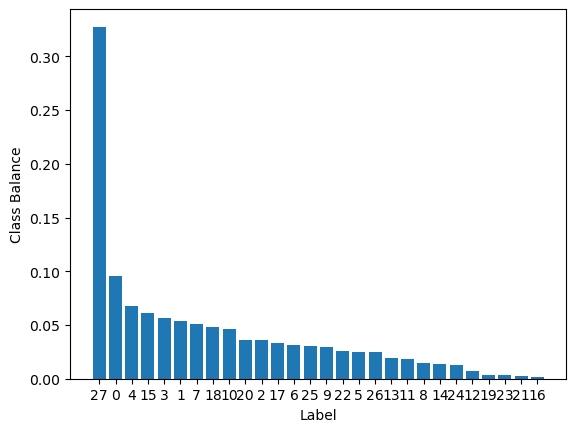

In [158]:
#Class Balance of training dataset before any changes are made
class_balance = calculate_class_balance(labels)
sorted_class_balance = dict(sorted(class_balance.items(), key=lambda item: item[1], reverse=True))
print(sorted_class_balance)
plot_class_balance(labels)

{27: 0.32546995945447843, 0: 0.08993733873940288, 4: 0.07316623663840767, 15: 0.06597862145226686, 1: 0.05584224106155548, 3: 0.05584224106155548, 10: 0.0538149649834132, 18: 0.04644305197198673, 7: 0.04570586067084408, 20: 0.03851824548470328, 2: 0.03593807593070402, 17: 0.0316992259491338, 9: 0.030040545521562847, 5: 0.02819756726870623, 6: 0.028013269443420568, 25: 0.026354589015849614, 26: 0.02377441946185035, 22: 0.023405823811279026, 11: 0.017876889052709177, 13: 0.017692591227423518, 14: 0.016586804275709546, 8: 0.014190932546995945, 24: 0.012532252119424991, 12: 0.006450423884998157, 19: 0.003870254330998894, 23: 0.003317360855141909, 21: 0.0027644673792849243, 16: 0.002395871728713601}


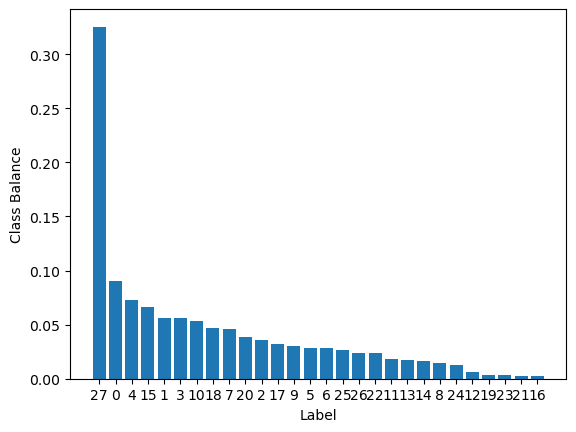

In [159]:
#Class Balance of validation dataset before any changes are made
class_balance = calculate_class_balance(labels2)
sorted_class_balance = dict(sorted(class_balance.items(), key=lambda item: item[1], reverse=True))
print(sorted_class_balance)
plot_class_balance(labels2)

{27: 0.3292795282845034, 0: 0.09286898839137644, 15: 0.06486088078127879, 4: 0.06467661691542288, 3: 0.05896443707388981, 7: 0.052330937903077204, 10: 0.04919845218352681, 1: 0.048645660585959094, 18: 0.04385480007370555, 2: 0.03648424543946932, 20: 0.03427307904919845, 17: 0.02966648240280081, 25: 0.028745163073521283, 6: 0.028192371475953566, 9: 0.027823843744241756, 22: 0.02671826054910632, 26: 0.025981205085682697, 5: 0.024875621890547265, 11: 0.022664455500276397, 13: 0.018979178183158283, 8: 0.01529390086604017, 14: 0.014372581536760642, 24: 0.010318776487930717, 12: 0.0068177630366685095, 19: 0.00423806891468583, 21: 0.0029482218536944905, 23: 0.002026902524414962, 16: 0.001105583195135434}


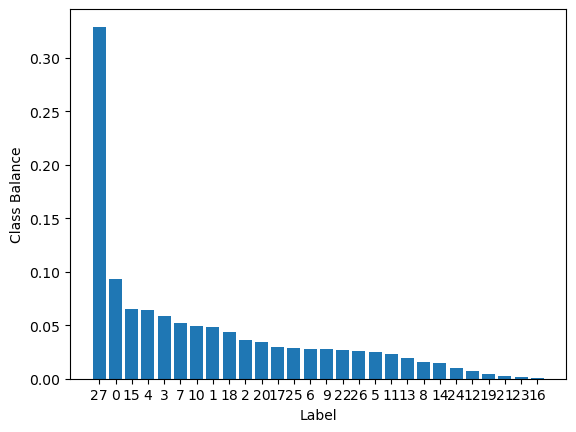

In [160]:
#Class Balance of testing dataset before any changes are made
class_balance = calculate_class_balance(labels3)
sorted_class_balance = dict(sorted(class_balance.items(), key=lambda item: item[1], reverse=True))
print(sorted_class_balance)
plot_class_balance(labels3)

**Notes:** Clear class imbalance in the data with class 27 making up the majority of the dataset.

## Labels being cut down to 14 and visulization of the class balance after this change

In [ ]:
#Cutting the labels down to 14
a_labels = remove_dupes(replace_labels(labels)) 
a_labels2 = remove_dupes(replace_labels(labels2))
a_labels3 = remove_dupes(replace_labels(labels3))

In [162]:
a_labels[:10]

[[13], [13], [2], [7], [2], [12], [0], [6, 8], [0], [13]]

As visible above, the labels are now in a range of 0-13 instead of 0-27, however, they still contain multiple labels for certain texts. To rectify this based on instructions given in the brief these will be converted into singular labels, and the way this will be done is using a function to change the multi-labelled texts to the label with the lowest class balance to avoid further disparities in class balancing. eg if a label = [6, 8] then this would be converted to 6 since 6 has a lower class balance than 8.

{13: 0.3275512554710896, 0: 0.25385855793595946, 2: 0.1432158488827459, 1: 0.10241879751209398, 11: 0.0751670122091684, 5: 0.050472241419027876, 8: 0.0364201796821009, 4: 0.03151347615756738, 9: 0.025570145127850726, 3: 0.025040313291868233, 12: 0.02441833678875835, 7: 0.016724257083621286, 6: 0.014766182907164247, 10: 0.0035245335176226677}


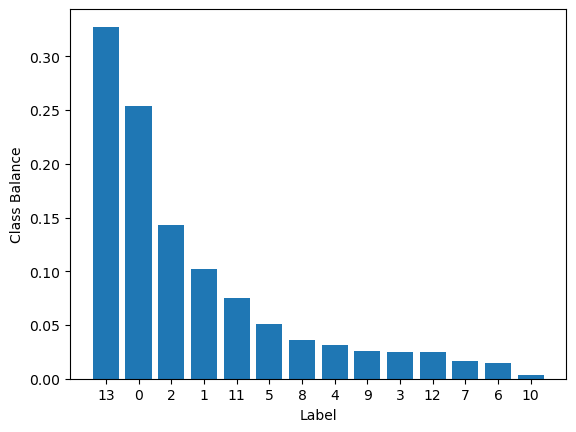

In [163]:
#training class balance after conversion to 14 labels
class_balance = calculate_class_balance(a_labels)
sorted_class_balance = dict(sorted(class_balance.items(), key=lambda item: item[1], reverse=True))
print(sorted_class_balance)
plot_class_balance(a_labels)

{13: 0.32546995945447843, 0: 0.2583855510504976, 2: 0.14725396240324365, 1: 0.10007371913011426, 11: 0.07187615186140804, 5: 0.04570586067084408, 8: 0.03851824548470328, 3: 0.02819756726870623, 4: 0.028013269443420568, 12: 0.02377441946185035, 9: 0.023405823811279026, 7: 0.01935127165499447, 6: 0.014190932546995945, 10: 0.003317360855141909}


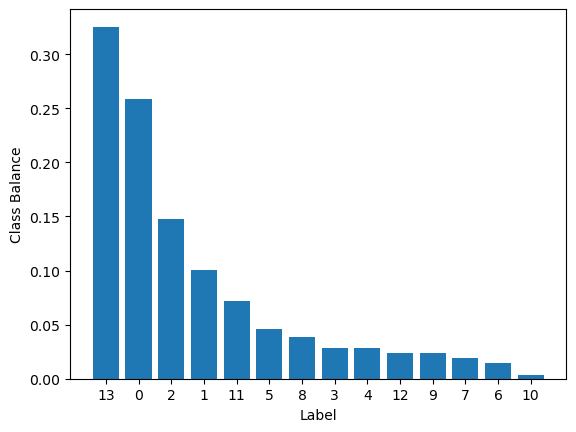

In [164]:
#validation class balance after conversion to 14 labels
class_balance = calculate_class_balance(a_labels2)
sorted_class_balance = dict(sorted(class_balance.items(), key=lambda item: item[1], reverse=True))
print(sorted_class_balance)
plot_class_balance(a_labels2)

{13: 0.3292795282845034, 0: 0.25096738529574353, 2: 0.15146489773355445, 1: 0.09397457158651189, 11: 0.06983600515938825, 5: 0.052330937903077204, 8: 0.03427307904919845, 4: 0.028192371475953566, 9: 0.02671826054910632, 12: 0.025981205085682697, 3: 0.024875621890547265, 7: 0.018057858853878755, 6: 0.01529390086604017, 10: 0.002026902524414962}


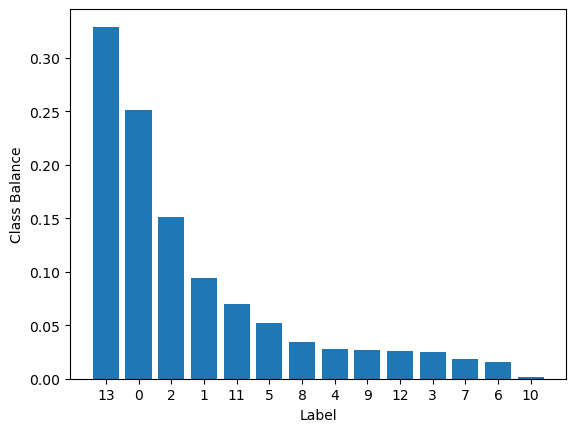

In [165]:
#testing class balance after conversion to 14 labels
class_balance = calculate_class_balance(a_labels3)
sorted_class_balance = dict(sorted(class_balance.items(), key=lambda item: item[1], reverse=True))
print(sorted_class_balance)
plot_class_balance(a_labels3)

Class imbalance still exists within data, however, the imbalance in the data at this point has somewhat improved compared to the original dataset.

## Labels being converted to contain only singular labels and visulization of the class balance after this change

In [166]:
dataset['train'] = dataset['train'].remove_columns('labels') # remove original labels and add new ones back to dataset
dataset['train'] = dataset['train'].add_column('labels', a_labels)
dataset['validation'] = dataset['validation'].remove_columns('labels')
dataset['validation'] = dataset['validation'].add_column('labels', a_labels2)
dataset['test'] = dataset['test'].remove_columns('labels')
dataset['test'] = dataset['test'].add_column('labels', a_labels3)

train = dataset["train"].to_pandas()
valid = dataset["validation"].to_pandas()
test = dataset["test"].to_pandas()
clear_output()

In [167]:
#Conversion of multi-classed labels to singular labels
dict_a = class_freq(dataset['train'])
dict_b = class_freq(dataset['validation'])
dict_c = class_freq(dataset['test'])
class_dict = Counter(dict_a) + Counter(dict_b) + Counter(dict_c)

a_labels1 = multilabel2multiclass(a_labels) 
a_labels22 = multilabel2multiclass(a_labels2)
a_labels33 = multilabel2multiclass(a_labels3)

In [168]:
a_labels1[:10]

[[13], [13], [2], [7], [2], [12], [0], [6], [0], [13]]

As visible in the output above, the labels are now in the correct format ranging from 0-13 and only containing a single label per class.

{13: 0.2953927666436305, 0: 0.25385855793595946, 2: 0.1360285648468095, 1: 0.08675420410043769, 11: 0.056945404284727025, 5: 0.038217000691085, 4: 0.02782768947247178, 8: 0.02275973278046533, 3: 0.020317899101589494, 12: 0.017300161253167474, 9: 0.01677032941718498, 7: 0.014305459571527297, 6: 0.011310757889887123, 10: 0.0022114720110573602}


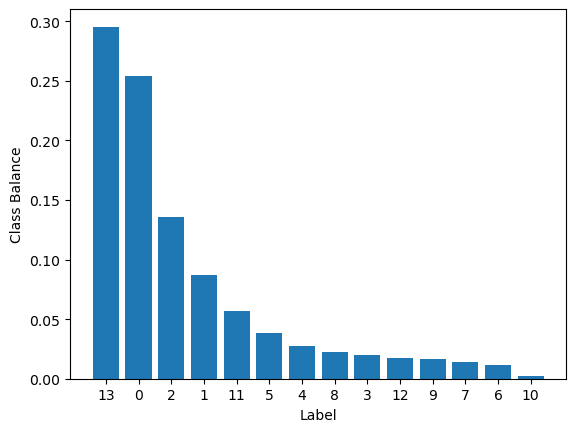

In [169]:
#training class balance of final dataset after labels have been converted
class_balance = calculate_class_balance(a_labels1)
sorted_class_balance = dict(sorted(class_balance.items(), key=lambda item: item[1], reverse=True))
print(sorted_class_balance)
plot_class_balance(a_labels1)

{13: 0.2934021378547733, 0: 0.2583855510504976, 2: 0.13859196461481754, 1: 0.08606708440840398, 11: 0.05197198673055658, 5: 0.035569480280132695, 4: 0.025064504238849983, 8: 0.024327312937707336, 3: 0.02395871728713601, 12: 0.017508293402137855, 9: 0.01695539992628087, 7: 0.01566531514928124, 6: 0.011057869517139697, 10: 0.001474382602285293}


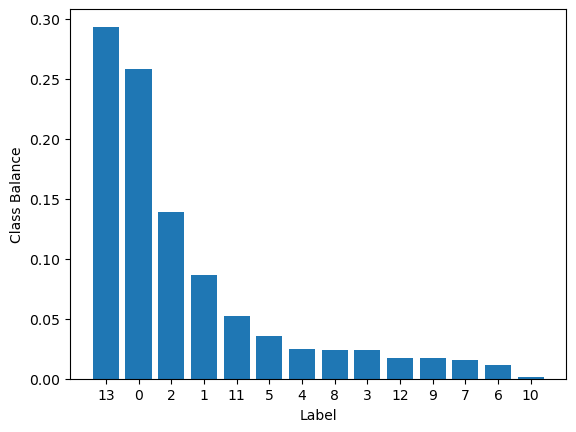

In [170]:
#validation class balance of final dataset after labels have been converted
class_balance = calculate_class_balance(a_labels22)
sorted_class_balance = dict(sorted(class_balance.items(), key=lambda item: item[1], reverse=True))
print(sorted_class_balance)
plot_class_balance(a_labels22)

{13: 0.29592776856458447, 0: 0.25096738529574353, 2: 0.14483139856274185, 1: 0.07868067072047172, 11: 0.05601621522019532, 5: 0.04072231435415515, 4: 0.023954302561267734, 8: 0.022295927768564584, 9: 0.020637552975861433, 3: 0.01861065045144647, 12: 0.01695227565874332, 7: 0.01658374792703151, 6: 0.012529942878201585, 10: 0.0012898470609913396}


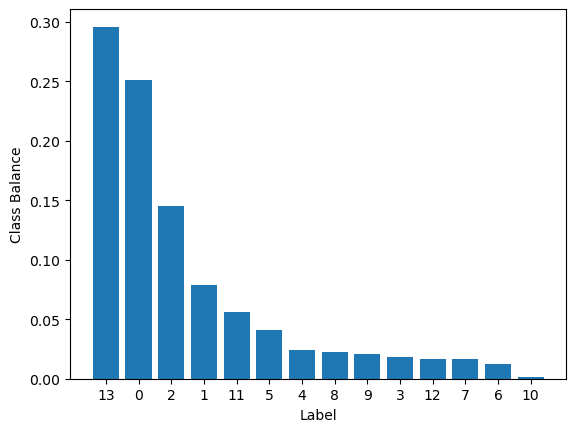

In [171]:
#testing class balance of final dataset after labels have been converted
class_balance = calculate_class_balance(a_labels33)
sorted_class_balance = dict(sorted(class_balance.items(), key=lambda item: item[1], reverse=True))
print(sorted_class_balance)
plot_class_balance(a_labels33)

**General notes about the class balance**  
As visible in the graphs that have been showcased so far, there is a clear class imbalance within the data. Most of the data belong to classes 13, 0, 2, and 1 ranked in order. This is not likely to impact the experiments well and ideally we would have a dataset with balanced classes. This would improve overall results, avoid overfitting to our data and make the models more applicable to general unseen data. It would also improve the model's ability to correctly classify the data from the lower represented classes. It is important to note that due to the class imbalance especially for class 10, it can be expected for models to be unable to perform well in classifying low represented classes.  
As a result of the clear class imbalance, the F1-score metric will be used along with accuracy; this is to address the class imbalance issue as F1-score takes into consideration both precision and recall. In an unbalanced dataset these two metrics are the most important as precision measures the proportion of true positives (TP) amongst all predictions made as positive, and recall measures the proportion of TPs amongst all actual positives.



In [172]:
dataset['train'] = dataset['train'].remove_columns('labels') # remove original labels and add new ones back to dataset
dataset['train'] = dataset['train'].add_column('labels', a_labels1)
dataset['validation'] = dataset['validation'].remove_columns('labels')
dataset['validation'] = dataset['validation'].add_column('labels', a_labels22)
dataset['test'] = dataset['test'].remove_columns('labels')
dataset['test'] = dataset['test'].add_column('labels', a_labels33)

train = dataset["train"].to_pandas()
valid = dataset["validation"].to_pandas()
test = dataset["test"].to_pandas()
clear_output()

# Structure and Breakdown of Experiments
There will be 4 different experiments conducted, and each of these 4 experiments will include variations within them. These will include the following variations totalling to 13 different variations:
* Experiment one will investigate the use of SVMs for the task at hand, however, it will also investigate the effect that changing the data split would have on the SVM.  
* Experiment two will investigate the use of GRUs for this task. A series of different GRU models (different layers, hyperparameters, and etc) will be investigated, and the best performing GRU model will be used to investigate the effects of different pre-processing techniques on this model. These will include tokenization, text cleaning, stemming and a combination of these techniques.  
* Experiment three will investigate the use of the bert model on the data. Variations of the bert model will be tested on the data, these will include different lengths used for the padding sequence of the tokenization process. These will include 33 and 128. Due to extremely high computational powers required only one variation of the 128 MAX_LEN will be tested, however, the 33 MAX_LEN model will be further investigated with different variations of layers and hyperparameters.
* Experiment four will follow the structure of experiment three, however, this experiment will investigate Microsoft's Deberta model instead of Google's Bert model. 
* All models will use categorical_crossentropy as their loss function and be evaluated using accuracy, F1-score and Confusion Matrix. The same callback function will be applied to all models in order to avoid overfitting these and save computational power.


# Experiment 1: Experimenting with SVMs and different data splits 
In this variation a simple SVM classifier will be investigated for classifying text into 14 categories. The data will be pre-processed by vectorizing it using the tfidvectorizer and passed on to a SVM classifier with model params of: (kernel='linear', C=1, random_state=42). This model will also be used to investigate using different training and testing splits on the data. The splits used will be 70:30 and 80:20 for training and testing respectively. Since the dataset is given to us in a split of 80:10:10 for training, validation, and testing, all of these will be combined into one dataset using a function and this dataset will then be split to the desired 70:30 and 80:20 splits using the train_test_split function. Vectorization will be applied to the text using the Tfidvectorizer which will convert the text to lowercase, as well as removing stopwords. The performance of the SVM with different splits will be evaluated using accuracy, f-1 score and confusion matrix to be able to compare the effects of the SVM with different splits.

In [114]:

combined_dataset_text = np.concatenate([dataset['train']['text'], dataset['validation']['text'], dataset['test']['text']], axis=0)
combined_dataset_labels = np.concatenate([dataset['train']['labels'], dataset['validation']['labels'], dataset['test']['labels']], axis=0)


## Variation 1
**SVM model with data split of 80:20**

In [21]:

# pre-process the text
vectorizer = TfidfVectorizer(stop_words='english', lowercase=True, strip_accents='unicode')
X = vectorizer.fit_transform(combined_dataset_text)#data['text']
y = combined_dataset_labels#data['label']

# split the data into training and testing sets with a 80:20 ratio 
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



# train an SVM classifier on the training data
clf = SVC(kernel='linear', C=1, random_state=42)
clf.fit(X_train, y_train)

# evaluate the model on the testing data
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print('Accuracy: {:.2f}%'.format(acc * 100))


f1_stem_20 = f1_score(y_test, y_pred, average='macro')
print(f1_stem_20)

cm_stem_20 = confusion_matrix(y_test, y_pred)

print("Confusion matrix:\n", cm_stem_20)

classification_stem_20 = classification_report(y_test, y_pred)
print(classification_stem_20)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 57.74%
0.37969025141135304
Confusion matrix:
 [[1919   99   57   13    1    5   13    7   30    3    0   22   16  660]
 [ 122  555   19    1    0    1    1    2   18    1    0    5   14  143]
 [  86   34  611    3    2    0    3    9   10    6    0   53    6  719]
 [  41    5    9   26    0    0    1    3   14    1    0    9    2  105]
 [  19    7   34    1   15    1    0    3    2    0    0   11    2  180]
 [  48    7   19    1    0   33    0    2    4    2    0   13    8  257]
 [   9    6    4    1    0    0   43    0    9    0    0    4    1   46]
 [   9    2   21    2    0    1    0   74    2    0    0    1    2   53]
 [  38    2    4    2    0    0    5    0  114    0    0    5    3   68]
 [   8    4    7    1    2    0    0    1    0   13    0    4    4  114]
 [  11    3    3    2    0    1    0    0    0    0    0    0    0   13]
 [  42   10   55    4    0    2    2    8    3    3    0  231    4  248]
 [  26    4   10    0    0    4    0    0    0    1    0    1   65  

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Discussion of Results**  
The SVM classifier was able to achieve an accuracy of 57.74% and an F1-score of 0.3797. Whilst the accuracy may seem somewhat acceptable, the F1-score shows the higher accuracy compared to the F1-score may be due to the class imbalance in the data. From looking at the confusion matrix we can see the model correctly classified labels 0,1,2,11,13 well compared to the other labels. This further showcases the class imbalance in the data affecting the results as these labels have the highest class balances in the data. This would explain the model's ability to correctly classify a large number of data belonging to classes 0 & 13 as these had the highest class balance in the data. The model also wrongfully classified a large portion of the data as classes 0 & 13 which further proves the effect of the class imbalance. It is important to note that due to this, the model did not classify any of the text as label 10. The model also had relatively low F1-scores for some other classes such as 3,4,5,and 9 indicating the model is not performing well at classifying these classes.  
From the clasification report we can conclude that the model's performance is being driven by the majorit classes and it is unable to perform well on minority classes. This can be derived from the macro-average F1-score (0.38) being significantly lower than the weighted-average F1-score (0.55).

## Variation 2
**SVM model with data split of 70:30**

In [22]:

# pre-process the text
vectorizer = TfidfVectorizer(stop_words='english', lowercase=True, strip_accents='unicode')
X = vectorizer.fit_transform(combined_dataset_text)#data['text']
y = combined_dataset_labels#data['label']

# split the data into training and testing sets with a 70:30 ratio 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



# train an SVM classifier on the training data
clf = SVC(kernel='linear', C=1, random_state=42)
clf.fit(X_train, y_train)

# evaluate the model on the testing data
y_pred = clf.predict(X_test)
acc_30 = accuracy_score(y_test, y_pred)

print('Accuracy: {:.2f}%'.format(acc_30 * 100))


f1_stem_30 = f1_score(y_test, y_pred, average='macro')
print(f1_stem_30)

cm_stem_30 = confusion_matrix(y_test, y_pred)

print("Confusion matrix:\n", cm_stem_30)

classification_stem_30 = classification_report(y_test, y_pred)
print(classification_stem_30)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 57.71%
0.3831983822178632
Confusion matrix:
 [[2829  164   84   13    3    6   21   13   43    4    0   33   18  961]
 [ 178  855   35    4    2    2    2    3   19    0    0   10   17  212]
 [ 133   62  892    2    3    1    5   12   14    5    0   71   14 1070]
 [  54    8   11   46    0    0    2    4   25    1    0   19    2  152]
 [  27   10   37    1   28    0    0    4    2    1    0   12    3  295]
 [  70   14   32    3    1   54    0    2    5    3    0   19   14  393]
 [  13    6    5    1    0    0   72    0   12    0    0    5    1   78]
 [  14    3   30    4    0    0    0   92    2    0    0    0    2   80]
 [  51   10    8    2    0    0    9    0  174    1    0    8    3  108]
 [  22    9   14    1    2    0    0    2    1   23    0    7    5  184]
 [  13    4    3    2    0    1    0    1    0    0    0    1    0   18]
 [  60   13   79    4    0    2    5    6    8    5    0  342    7  391]
 [  40    7   14    0    0    4    2    0    0    1    0    1   96  1

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Increasing the split from 80:20 to 70:30 did not have much of an impact. The accuracy went down slightly to 57.71%, however, the F1-score went up slightly to 0.3832. This slight increased performance can be witnessed in the confusion matrix. The confusion matrix and classification report results are similar to the other SVM variation. the same classes were classified well and the same ones not well as the previous variation.

## Conclusion:
Whilst the SVM model using a 70:30 split performed just worst in regards to accuracy, it was able to outperform the 80:20 split regarding f1-score. This showcases that 70:30 is the better split to use for this model due to the class imbalance in the dataset. The extremely small number of instances from classes 9 & 10 existing in the dataset could be the reason for these model's bad performance regarding these two classes.

# Experiment 2 pre-processing
Application of one-hot encoding to the data to be used for the other variations.  
When running this notebook, to test different variations of the GRU model (variation 2), you will be required to uncomment and run specific cells for specific variations. For the first GRU variation its not required to uncomment any code, however, for the other variations theres markdown comments above the relevant cells.

In [ ]:
train_ohe_labels = one_hot_encoder(train).values.tolist() # replace labels column in 'dataset' with one-hot-encoded labels
valid_ohe_labels = one_hot_encoder(valid).values.tolist()
test_ohe_labels = one_hot_encoder(test).values.tolist()

dataset['train'] = dataset['train'].remove_columns('labels')
dataset['train'] = dataset['train'].add_column('labels', train_ohe_labels)
dataset['validation'] = dataset['validation'].remove_columns('labels')
dataset['validation'] = dataset['validation'].add_column('labels', valid_ohe_labels)
dataset['test'] = dataset['test'].remove_columns('labels')
dataset['test'] = dataset['test'].add_column('labels', test_ohe_labels)

In [174]:

y_train_bert = np.asarray(dataset['train']['labels'], dtype='int32')
y_test_bert = np.asarray(dataset['test']['labels'], dtype='int32')
y_valid_bert = np.asarray(dataset['validation']['labels'], dtype='int32')


In [175]:

# create a new column to store the number of words in each text
train['num_words'] = train['text'].apply(lambda x: len(x.split()))

# sort the dataframe by the number of words in descending order
df_sorted = train.sort_values('num_words', ascending=False)

# get the text with the longest number of words
longest_text = df_sorted.iloc[0]['text']

# get the number of words in the longest text
num_words_longest_text = df_sorted.iloc[0]['num_words']

# print the results
print("The text with the longest number of words is:\n", longest_text)
print(num_words_longest_text, "words.")

train = train.drop('num_words', axis=1)

The text with the longest number of words is:
 When you look back at your picks and realize you’re laying pretty much entirely chalk Tenn -8 Bowling Green -4 Akron -1 NC STATE -1.5 Duke -21 MSU This should go well lol
33 words.


**Uncomment and run for cleaning variation**

In [33]:
#train['text'] = train['text'].apply(clean_text)
#valid['text'] = valid['text'].apply(clean_text)
#test['text'] = test['text'].apply(clean_text)

In [47]:

# create a new column to store the number of words in each text
train['num_words'] = train['text'].apply(lambda x: len(x.split()))

# sort the dataframe by the number of words in descending order
df_sorted = train.sort_values('num_words', ascending=False)

# get the text with the longest number of words
longest_text = df_sorted.iloc[0]['text']

# get the number of words in the longest text
num_words_longest_text = df_sorted.iloc[0]['num_words']

# print the results
print("The text with the longest number of words is:\n", longest_text)
print("It has", num_words_longest_text, "words.")

train = train.drop('num_words', axis=1)

The text with the longest number of words is:







 go gameshomeawayteamvs wl 1819 110golden state01 211houston00 211oklahoma city00 202toronto11 211milwaukee01 312indiana01 211philadelphia11 211boston10 110minnesota01 211new orleans00 211memphis00 110dallas01 101miami21 321brooklyn00 211charlotte02 202detroit11 211washington11 211new york20 211cleveland10 422atlanta00 110chicago21







It has 29 words.


**Uncomment and run for stemming variation**

In [76]:
#train['text'] = train['text'].apply(stem_text)
#valid['text'] = valid['text'].apply(stem_text)
#test['text'] = test['text'].apply(stem_text)

**Uncomment and run for cleaning and stemming variation**

In [117]:
#train['text'] = train['text'].apply(clean_text)
#valid['text'] = valid['text'].apply(clean_text)
#test['text'] = test['text'].apply(clean_text)

#train['text'] = train['text'].apply(stem_text)
#valid['text'] = valid['text'].apply(stem_text)
#test['text'] = test['text'].apply(stem_text)

In [118]:
# The maximum number of words to be used
MAX_NB_WORDS = 50000
# Max number of words in each text
MAX_SEQUENCE_LENGTH = 33
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(train['text'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 20135 unique tokens.


In [119]:
X_train = tokenizer.texts_to_sequences(train['text'].values)
X_train = pad_sequences(X_train, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X_train.shape)

X_test = tokenizer.texts_to_sequences(test['text'].values)
X_test = pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X_test.shape)

X_valid = tokenizer.texts_to_sequences(valid['text'].values)
X_valid = pad_sequences(X_valid, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X_valid.shape)

Shape of data tensor: (43410, 33)
Shape of data tensor: (5427, 33)
Shape of data tensor: (5426, 33)


In [120]:
labels = train['labels']




training_padded = np.array(X_train)
training_labels = np.array(dataset['train']['labels'])
testing_padded = np.array(X_test)
testing_labels = np.array(dataset['test']['labels'])
valid_padded = np.array(X_valid)
valid_labels = np.array(dataset['validation']['labels'])

# Experiment 2 GRU
  **Experimentation was conducted on using different model layers and parameters:**
* Model Layers: Embedding can be used to transform text data into a vector representation that is easy to process for recurrent layers. In this process, the embedding layer maps each word in the input vocabulary to a unique vector representation of that word which allows the model to capture semantic relationships between words. The first layer of the model is an embedding layer and the output of this layer (vectorized words) will be fed into the GRU model. Different number of GRU layers experiemented with were 1 and 2 and these were tested with Unit numbers of 64, 100, 128 and 150. Both unidirecetional and bidirectional GRU layers were experimented with, however, it was found that Bidirectional GRUs with 150 units performed best. After this experiment it was decided to go with a 2 layered Bidirectional-GRU model each containing 150 units. Dropout layers are added to avoid overfitting after each GRU layer. Different Dropout rates were also experiemnted with but 0.5 was found to be the optimal choice. Finally a Dense layer with softmax activation is used to calculate the probabilities for each of the 14 classes. This model will use categorical_crossentropy as it's loss function because of the nature of the task at hand. The optimizers experimented with during this task were adam and rmsprop, and the later performed best. 
* After obtaining the model structure explained above through analysis, research, and trial and error, the model designed will be experimented with different types of pre-processing. These will include the following:
        -application of the model to the data with no text pre-processing other than tokenization (no text cleaning or stemming) 
        -application of the model to text data after text cleaning and tokenization are applied.  
        -application of the model to the text data after stemming and tokenization are applied.  
        -finally, the application of the model to the text data after text cleaning, stemming and tokenization have been applied.  

 


In [121]:

model = Sequential()
model.add(Embedding(MAX_NB_WORDS, 100, input_length=X_train.shape[1]))
model.add(Bidirectional(GRU(150, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(GRU(150, return_sequences=False)))
model.add(Dropout(0.5))
model.add(Dense(14, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
print(model.summary())


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 33, 100)           5000000   
                                                                 
 bidirectional_6 (Bidirectio  (None, 33, 300)          226800    
 nal)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 33, 300)           0         
                                                                 
 bidirectional_7 (Bidirectio  (None, 300)              406800    
 nal)                                                            
                                                                 
 dropout_7 (Dropout)         (None, 300)               0         
                                                                 
 dense_3 (Dense)             (None, 14)               

In [29]:

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [122]:
history = model.fit(training_padded, training_labels, epochs=10, batch_size=32, validation_data = (valid_padded, valid_labels), callbacks= early_stopping)

Epoch 1/10
1357/1357 [==============================] - 36s 22ms/step - loss: 1.6653 - accuracy: 0.4864 - val_loss: 1.4397 - val_accuracy: 0.5579
Epoch 2/10
1357/1357 [==============================] - 22s 16ms/step - loss: 1.3902 - accuracy: 0.5807 - val_loss: 1.3985 - val_accuracy: 0.5732
Epoch 3/10
1357/1357 [==============================] - 21s 16ms/step - loss: 1.2847 - accuracy: 0.6088 - val_loss: 1.3400 - val_accuracy: 0.5853
Epoch 4/10
1357/1357 [==============================] - 21s 15ms/step - loss: 1.1979 - accuracy: 0.6326 - val_loss: 1.3724 - val_accuracy: 0.5820
Epoch 5/10
1357/1357 [==============================] - 22s 16ms/step - loss: 1.1190 - accuracy: 0.6568 - val_loss: 1.3863 - val_accuracy: 0.5759
Epoch 6/10
1357/1357 [==============================] - 21s 15ms/step - loss: 1.0386 - accuracy: 0.6848 - val_loss: 1.4495 - val_accuracy: 0.5564


## Variation 1
**only tokenizing data**

In [32]:
pred = model.predict(testing_padded)
predictions = np.argmax(pred, axis = -1)


y_true = np.argmax(testing_labels, axis = -1)
y_pred = predictions

acc = accuracy_score(y_true, y_pred)
print(acc)

f1 = f1_score(y_true, y_pred, average='macro')
print(f1)

cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix:\n", cm)

classification = classification_report(y_true, y_pred)
print(classification)

170/170 [==============================] - 1s 6ms/step
0.5922240648608808
0.40220909958989803
Confusion matrix:
 [[ 939   62   53    6    6    7    4    4    8    1    0   14    5  253]
 [  38  298    8    0    3    2    2    1    1    0    0    2    1   71]
 [  34   24  433    0    7    6    0    9    2    0    0   23    1  247]
 [   9    4   12   18    1    1    1    1    5    0    0    3    0   46]
 [   4    3   20    1   26   17    0    0    0    0    0    4    1   54]
 [  10    7   17    1    7   41    0    3    3    0    0    4    6  122]
 [   8    3    7    0    0    0   18    1    5    1    0    2    0   23]
 [   3    1   17    1    1    0    0   51    0    1    0    2    0   13]
 [  23    7    6    3    0    0    4    1   42    0    0    7    0   28]
 [   8    7   12    0    2    5    0    1    0    2    0    7   10   58]
 [   1    1    1    0    0    0    0    1    0    0    0    1    0    2]
 [  12    9   51    1    5    3    1    6    1    0    0  138    3   74]
 [   3    4

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The results displayed above showcase the application of the GRU model on the tokenized data. The tokenizer filters punctuation and converts the text to lower case. These results showcase the models performance, achieving an accuracy of 59.22% and an F1-score of 0.4022. The class with the highest precision was 0 at 79% meaning out of all samples the model predicted 0, 79% of them were actually 0. On the other hand, class 10 has a precision of 0. recall for class 9 is low at 2% meaning only 2% of the samples belonging to class 9 were correctly classified. classes 9 and 10 had low F1-scores again whilst classes 0, 1 and 13 had the highest F1-scores.  
It is important to note that this version of the GRU model was able to achieve the best results in experiment 2. Whilst the 4th variation performed better with regards to the accuracy metric, This variation scored a better F1-score, therefore, due to the nature of the dataset the F1-score is regarded the more important metric. 

## Variation 2
**Cleaning and tokenizing data**

In [53]:
pred_clean_text = model.predict(testing_padded)
predictions_text = np.argmax(pred_clean_text, axis = -1)


y_true = np.argmax(testing_labels, axis = -1)
y_pred = predictions_text


acc_clean = accuracy_score(y_true, y_pred)
print(acc_clean)

f1_clean = f1_score(y_true, y_pred, average='macro')
print(f1_clean)

cm_clean = confusion_matrix(y_true, y_pred)
print("Confusion matrix:\n", cm_clean)


170/170 [==============================] - 2s 5ms/step







0.5795098581168233







0.37214063640919115







Confusion matrix:







 [[ 967   49   64    2    2    0    1    4   10    0    0    2    2  259]







 [  55  283   18    0    1    0    0    0    0    0    0    1    3   66]







 [  44   24  420    1    2    0    0    5    2    0    0   14    2  272]







 [   8    6   15   18    0    0    0    1    4    0    0    2    0   47]







 [   6    3   22    1   14    1    0    0    0    0    0    4    2   77]







 [  26    5   19    2    2   13    1    2    2    0    0    2    8  139]







 [  10    3    2    2    0    0   12    0    4    0    0    2    0   33]







 [   3    1   24    2    0    0    0   45    0    0    0    2    1   12]







 [  22    7    4    1    0    0    3    0   50    0    0    1    1   32]







 [  12    6    9    0    0    2    2    0    0    0    0    6   10   65]







 [   1    1    1    0    0    0    0    1    0    0    0   

In [41]:
classification = classification_report(y_true, y_pred)
print(classification)

              precision    recall  f1-score   support

           0       0.71      0.74      0.72      1362
           1       0.66      0.68      0.67       427
           2       0.57      0.42      0.49       786
           3       0.38      0.14      0.20       101
           4       0.41      0.12      0.18       130
           5       0.50      0.04      0.08       221
           6       0.57      0.12      0.20        68
           7       0.64      0.52      0.57        90
           8       0.55      0.35      0.42       121
           9       0.00      0.00      0.00       112
          10       0.00      0.00      0.00         7
          11       0.53      0.51      0.52       304
          12       0.41      0.30      0.35        92
          13       0.52      0.76      0.62      1606

    accuracy                           0.58      5427
   macro avg       0.46      0.34      0.36      5427
weighted avg       0.57      0.58      0.55      5427



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The results displayed above showcase the application of the GRU model on the tokenized data after cleaning text. the clean text function removes stop words, converts the text to lower-case and removes punctuation in the text. an accuracy of 57.95% and F1-score of 0.3721 was achieved. The results of the confusion matrix is simiar to the previous GRU variation described. These results show that the application of the clean text function has slightly decreased the performance of the GRU model in comparison to only tokenizing the data. The weighted avergage score of 0.55 indicates that the model is better at classifying some classes to others, this was also the case with the previous GRU variation.

## Variation 3
**Stemming and tokenizing data**

In [92]:
pred_stem = model.predict(testing_padded)
predictions_stem = np.argmax(pred_stem, axis = -1)

y_true = np.argmax(testing_labels, axis = -1)
y_pred = predictions_stem

acc_stem = accuracy_score(y_true, y_pred)
print(acc_stem)
f1_stem = f1_score(y_true, y_pred, average='macro')
print(f1_stem)
cm_stem = confusion_matrix(y_true, y_pred)
print("Confusion matrix:\n", cm_stem)

170/170 [==============================] - 2s 5ms/step







0.583932190897365







0.3763341105372289







Confusion matrix:







 [[ 993   47   67    5    5    4    0    1   14    0    0    4    6  216]







 [  60  282    9    0    1    5    0    0    2    0    0    2    3   63]







 [  52   24  421    1    9    3    0    4    2    0    0   15    1  254]







 [  15    5    8   17    1    0    0    1    6    0    0    1    0   47]







 [   8    3   21    1   22   17    0    0    1    0    0    3    1   53]







 [  17    6   15    0    7   38    0    3    5    0    0    5    5  120]







 [  14    6   11    1    0    0    7    0    5    0    0    2    0   22]







 [   3    1   20    1    1    0    0   44    0    0    0    5    0   15]







 [  21    4    4    5    0    0    3    0   53    0    0    1    0   30]







 [  18    8   16    0    1    0    0    0    0    2    0    9    9   49]







 [   2    1    2    0    0    0    0    0    0    0    0    1

In [82]:
classification_stem = classification_report(y_true, y_pred)
print(classification_stem)

170/170 [==============================] - 2s 5ms/step
              precision    recall  f1-score   support

           0       0.62      0.78      0.69      1362
           1       0.65      0.62      0.64       427
           2       0.63      0.38      0.48       786
           3       0.36      0.12      0.18       101
           4       0.47      0.11      0.18       130
           5       0.37      0.26      0.30       221
           6       0.55      0.16      0.25        68
           7       0.68      0.54      0.60        90
           8       0.54      0.40      0.46       121
           9       1.00      0.04      0.07       112
          10       0.00      0.00      0.00         7
          11       0.67      0.38      0.48       304
          12       0.51      0.24      0.33        92
          13       0.52      0.73      0.61      1606

    accuracy                           0.58      5427
   macro avg       0.54      0.34      0.38      5427
weighted avg       0.58  

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The results displayed above showcase the application of the GRU model on the tokenized data after stemming. Stemming is the process of reducing words to their base form to reduce the size of the vocabulary. An accuracy of 58.39% and F1-score of 0.3763 was achieved. The results of the confusion matrix is simiar to the previous GRU variation described. These results show that the application of the stemming function has slightly increased the performance of the GRU model in comparison to cleaning the text, however, it still was unable to outperform the results when only tokenizing the data. similarly to previous variations the model classified classes 0,1 and 13 but struggled with 3,4,5,6,8,12 and especially 9&10.

## Variation 4
**Cleaning, stemming and tokenizing data**

In [30]:
pred_stem_clean = model.predict(testing_padded)
predictions_stem_clean = np.argmax(pred_stem_clean, axis = -1)


y_true = np.argmax(testing_labels, axis = -1)
y_pred = predictions_stem_clean

acc_stem_clean = accuracy_score(y_true, y_pred)
print(acc_stem_clean)
f1_stem_clean = f1_score(y_true, y_pred, average='macro')
print(f1_stem_clean)
cm_stem_clean = confusion_matrix(y_true, y_pred)
print("Confusion matrix:\n", cm_stem_clean)

170/170 [==============================] - 2s 5ms/step

0.5931453841901603

0.3895208916995369

Confusion matrix:

 [[ 985   37   43    4    3    1    1    6   18    0    0   16    9  239]

 [  58  285    9    0    0    0    0    1    0    0    0    3    5   66]

 [  53   20  345    1    3    0    0    8    2    1    0   31    6  316]

 [  10    5   12   18    1    0    0    1    7    1    0    5    0   41]

 [   7    4    8    2   21    0    0    0    0    0    0    6    2   80]

 [  29    2    9    2    3   10    1    3    3    0    0    7    9  143]

 [  10    3    2    3    0    0   12    0    5    0    0    2    0   31]

 [   1    0   14    4    0    0    0   48    0    0    0    4    0   19]

 [   9    6    2    3    0    0    3    0   61    0    0    1    1   35]

 [  10    7    5    2    0    1    0    0    0    8    0    6   12   61]

 [   0    1    1    1    0    0    0    1    0    0    0    1    0    2]

 [  18   11   24    4    1    0    0    2    6    0    0  143    3   9

In [123]:
classification_stem_clean = classification_report(y_true, y_pred)
print(classification_stem_clean)

170/170 [==============================] - 2s 5ms/step
              precision    recall  f1-score   support

           0       0.69      0.76      0.72      1362
           1       0.67      0.68      0.68       427
           2       0.55      0.47      0.51       786
           3       0.32      0.12      0.17       101
           4       0.44      0.22      0.29       130
           5       0.62      0.04      0.07       221
           6       0.61      0.21      0.31        68
           7       0.68      0.54      0.60        90
           8       0.65      0.35      0.45       121
           9       0.80      0.04      0.07       112
          10       0.00      0.00      0.00         7
          11       0.57      0.50      0.53       304
          12       0.38      0.27      0.32        92
          13       0.53      0.73      0.61      1606

    accuracy                           0.59      5427
   macro avg       0.54      0.35      0.38      5427
weighted avg       0.59  

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The results displayed above showcase the application of the GRU model on the tokenized data after cleaning and stemming the text. An accuracy of 59.31% and F1-score of 0.3895 was achieved. The results of the confusion matrix is simiar to the previous GRU variation described, however, it is important to note that this variation had the highest number of correctly classified texts belonging to label 9 which is the second most poorly classified class in the data. These results show that the application of the cleaning and stemming function has slightly increased the performance of the GRU model in comparison to just stemming the text, however, when it came to comparing this model to the first GRU variation which only tokenized the data; this variation performed better regarding accuracy, but the slight superior score of the first GRU variation with regards to the F1-score makes the first variation (only tokenizing) the best GRU variation in this experiment.  
From the classification report we can summarize that classes 0,1,7,8,9,11 and 13 were correctly classified as their respective classes by the model (precision). the recall indicates the percentage of true positives correctly classified by the model and the model performed well with regards to recall for classes 0,1,11 and 13.

# Conclusion
Overall from te GRU variations experimented with the first variation was the best performing. Whilst the final variation had a slightly higher accuracy, the superior F1-score of the first variation shows this was the better model considering the dataset and its class imbalance.  
This showcases that the application of the clean text function or stemming alone is not likely to improve the performance of a GRU model, however, when both stemming and clean text functions are applied the model is able to achieve similar performance to just tokenizing the data so we can conclude that stemming and cleaning the text before feeding it to a GRU model may improve the results based on the task at hand, however, in this situation it was unable to cause an increase in the performance of the model.

# Experiment 3 & 4 pre-processing for transformers 
Here the data is tokenized using the tokenizers for each of the pre-trained transformers used (bert and deberta) depending on which transformer variation is attempting to be ran, uncomment the one being used and comment out the other tokenizer.

In [176]:

#tokenizer = DebertaTokenizer.from_pretrained("microsoft/deberta-base")

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

MAX_LEN = 33
#MAX_LEN = 128

In [177]:
X_train = dataset['train']['text']
X_test = dataset['test']['text']

X_train_bert = encode(X_train, tokenizer)
X_test_bert = encode(X_test, tokenizer)

y_train_bert = np.asarray(y_train_bert, dtype='int32')
y_test_bert = np.asarray(y_test_bert, dtype='int32')

In [178]:
y_valid_bert = np.asarray(dataset['validation']['labels'], dtype='int32')

X_valid = dataset['validation']['text']
X_valid_bert = encode(X_valid, tokenizer)
y_valid_bert = np.asarray(y_valid_bert, dtype='int32')

# Bert Transformer Model Experiment 3 
The Bert transformer model will be applied to the data to investigate it's performance. The bert model is a transformer architecture that processes input sequences by encoding and decoding them using attention mechanisms. This gives them the ability to capture long-range dependecies in the input sequence in comparison to RNN structures such as LSTMs and GRUs.  
Variations of the bert_base_uncased transformer model will be investigated. There will be 3 variations of this model investigated with sequence padding length of 33 (maximum number of words in trining set) when tokenizing and an application of one of these with a MAX_LEN for padding of 128 as this would take lots of time and computational power to train (~30 mins per epoch); for this reason for the final variation only the output of the evaluation cells have been included.  
The three variations of the Bert model being investigated with MAX_LEN = 32 are as followed:  
* bert-base-uncased pretrained transformer model followed by a GRU layer with 150 units, 0.5 Dropout layer, followed by a flatten layer which is followed by two dense layers. These include two fully connected dense layers, with the first layer having 256 units and ReLU activation function, and the second layer having n_categories units which is set to 14 and sigmoid activation function, which outputs a probability for each class. The model is trained with the Adam optimizer with a learning rate of 1e-5 and categorical cross-entropy loss function. 
* The second model is a very similar arhitecture to the first bert variation, with the only difference being the removal of the GRU layer from the model. Everything else is exactly the same as the first variation; this was done to observe the impact of adding additional RNNs to a pre-trained transformer model.
* The third bert variation is similar to second variation with the only differences being a lower dropout rate of 0.3 and a lower learning rate of 3e-6. This variation was done to observe the difference the learning rate and dropout layers could make to this model.
* Finally the 4th bert variation is the application of the third variation on data tokenized with MAX_LEN for padding sequence of 128. This model took around 30 minutes per epoch so only the results from this are available on this notebook.



**Bert tokenized with MAX_LEN = 33**

## Variation 1
**bert with GRU and 1e-5 lr and 0.5 dropout**

In [127]:
def build_model(n_categories):

    input_word_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_word_ids')
    input_mask = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_mask')
    input_type_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_type_ids')


    # Import transformer model from HuggingFace

    #transformer_model = TFAutoModelForSequenceClassification.from_pretrained("microsoft/deberta-base", num_labels=n_categories, problem_type="multi_label_classification")
    transformer_model = TFAutoModel.from_pretrained('bert-base-uncased', num_labels=n_categories)

    
    x = transformer_model(input_word_ids, attention_mask=input_mask, token_type_ids=input_type_ids)

    # Huggingface transformers have multiple outputs, embeddings are the first one,
    # so let's slice out the first position
    x = x[0]
    x = tf.keras.layers.GRU(150)(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dense(n_categories, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=x)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
        loss='categorical_crossentropy',
        metrics=['accuracy'])

    return model

In [ ]:
model = build_model(14)

In [129]:
#bert
history = model.fit(X_train_bert,
                    y_train_bert,
                    epochs = 10,
                    batch_size=32,
                    verbose=1,
                    validation_data=(X_valid_bert, y_valid_bert),
                    callbacks=[early_stopping]
                    )

Epoch 1/10
1357/1357 [==============================] - 403s 262ms/step - loss: 1.5011 - accuracy: 0.5348 - val_loss: 1.1530 - val_accuracy: 0.6307
Epoch 2/10
1357/1357 [==============================] - 349s 257ms/step - loss: 1.1502 - accuracy: 0.6360 - val_loss: 1.1000 - val_accuracy: 0.6395
Epoch 3/10
1357/1357 [==============================] - 348s 256ms/step - loss: 1.0236 - accuracy: 0.6706 - val_loss: 1.1048 - val_accuracy: 0.6353
Epoch 4/10
1357/1357 [==============================] - 348s 256ms/step - loss: 0.9187 - accuracy: 0.7033 - val_loss: 1.1155 - val_accuracy: 0.6447
Epoch 5/10
1357/1357 [==============================] - 342s 252ms/step - loss: 0.8082 - accuracy: 0.7419 - val_loss: 1.1681 - val_accuracy: 0.6364


In [130]:
pred_bert_lr_GRU = model.predict(X_test_bert)
predictions_bert_lr_GRU = np.argmax(pred_bert_lr_GRU, axis = -1)


y_true = np.argmax(y_test_bert, axis = -1)
y_pred = predictions_bert_lr_GRU

acc_bert_lr_GRU = accuracy_score(y_true, y_pred)
print(acc_bert_lr_GRU)
f1_bert_lr_GRU = f1_score(y_true, y_pred, average='macro')
print(f1_bert_lr_GRU)
cm_bert_lr_GRU = confusion_matrix(y_true, y_pred)
print("Confusion matrix:\n", cm_bert_lr_GRU)

classification_bert_lr_GRU = classification_report(y_true, y_pred)
print(classification_bert_lr_GRU)

170/170 [==============================] - 17s 82ms/step
0.6408697254468398
0.4731177442027113
Confusion matrix:
 [[1054   51   45    6    0    0    1    2   19    0    0   11    6  167]
 [  51  313    5    0    2    4    1    2    7    0    0    1    7   34]
 [  27   18  501    1    8    3    0    7    3    0    0   28    5  185]
 [  10    4    6   25    1    0    2    1    8    0    0    3    0   41]
 [   5    3   17    1   42   18    0    0    0    0    0    2    2   40]
 [  16    3   14    1    5   70    0    3    3    0    0    5   10   91]
 [   5    3    3    0    0    0   33    1    5    0    0    4    0   14]
 [   2    0   14    2    0    0    0   51    0    0    0    8    1   12]
 [  10    7    0    2    0    1    4    0   67    0    0    1    1   28]
 [  11    9   10    0    1    0    0    0    0    4    0    7   10   60]
 [   3    1    0    1    0    0    0    0    0    0    0    1    0    1]
 [   8    3   53    1    4    3    3    3    4    0    0  161    3   58]
 [  10    

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The bert-GRU variation was able to achieve an accuracy of 64.09% and an F1-score of 0.4731 which is significantly an improvement on experiments 1&2. The only label in which this model was unable to correctly classify any instances of is label 10, however, this is somewhat expected as there are only 7 instances of this label in the whole of the test set. As expected the usage of the BERT model has increased the performance significantly as even though 64% may not seem eextremly high, it is a very good score when considering the task at hand, other benchmark results and the quality of the dataset. Similarly to other models the BERT model also managed to classify labels 0,1,2,11&13 as well as label 5. The macro average f1-score of 0.47 indicates uneven performance among classes and with this considered, the weighted average f1-score of 0.63 indicates the model's performance is reasonable but influenced by the class imbalance.

## Variation 2
**bert with 1e-5 lr and 0.5 dropout**

In [132]:
def build_model(n_categories):

    input_word_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_word_ids')
    input_mask = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_mask')
    input_type_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_type_ids')


    # Import transformer model from HuggingFace

    #transformer_model = TFAutoModelForSequenceClassification.from_pretrained("microsoft/deberta-base", num_labels=n_categories, problem_type="multi_label_classification")
    transformer_model = TFAutoModel.from_pretrained('bert-base-uncased', num_labels=n_categories)

    
    x = transformer_model(input_word_ids, attention_mask=input_mask, token_type_ids=input_type_ids)

    # Huggingface transformers have multiple outputs, embeddings are the first one,
    # so let's slice out the first position
    x = x[0]

    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dense(n_categories, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=x)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
        loss='categorical_crossentropy',
        metrics=['accuracy'])

    return model

In [133]:
#bert
model = build_model(14)
history = model.fit(X_train_bert,
                    y_train_bert,
                    epochs = 10,
                    batch_size=32,
                    verbose=1,
                    validation_data=(X_valid_bert, y_valid_bert),
                    callbacks=[early_stopping]
                    )

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/10
1357/1357 [==============================] - 400s 262ms/step - loss: 1.4012 - accuracy: 0.5400 - val_loss: 1.0970 - val_accuracy: 0.6310
Epoch 2/10
1357/1357 [==============================] - 346s 255ms/step - loss: 1.0619 - accuracy: 0.6368 - val_loss: 1.0614 - val_accuracy: 0.6379
Epoch 3/10
1357/1357 [==============================] - 346s 255ms/step - loss: 0.9467 - accuracy: 0.6735 - val_loss: 1.0503 - val_accuracy: 0.6379
Epoch 4/10
1357/1357 [==============================] - 345s 254ms/step - loss: 0.8348 - accuracy: 0.7074 - val_loss: 1.0839 - val_accuracy: 0.6338
Epoch 5/10
1357/1357 [==============================] - 344s 253ms/step - loss: 0.7156 - accuracy: 0.7480 - val_loss: 1.1501 - val_accuracy: 0.6275
Epoch 6/10
1357/1357 [==============================] - 337s 248ms/step - loss: 0.5874 - accuracy: 0.7918 - val_loss: 1.2957 - val_accuracy: 0.6100


In [134]:
pred_bert_lr = model.predict(X_test_bert)
predictions_bert_lr = np.argmax(pred_bert_lr, axis = -1)


y_true = np.argmax(y_test_bert, axis = -1)
y_pred = predictions_bert_lr

acc_bert_lr = accuracy_score(y_true, y_pred)
print(acc_bert_lr)
f1_bert_lr = f1_score(y_true, y_pred, average='macro')
print(f1_bert_lr)
cm_bert_lr = confusion_matrix(y_true, y_pred)
print("Confusion matrix:\n", cm_bert_lr)

classification_bert_lr = classification_report(y_true, y_pred)
print(classification_bert_lr)

170/170 [==============================] - 17s 85ms/step
0.630919476690621
0.4861113476724421
Confusion matrix:
 [[1103   38   39   16    9   11    0    4   22    1    0   13    4  102]
 [  59  292    8    1    5    9    2    2    7    2    0    1    9   30]
 [  38   13  479    7   33   14    0   10    3    2    0   26    6  155]
 [   9    3    3   49    0    0    1    1    7    0    0    3    0   25]
 [   4    2    7    1   77   19    0    0    0    1    0    3    2   14]
 [   7    1    5    1   76   94    0    3    3    0    0    5    3   23]
 [  11    4    5    1    0    0   24    1    7    0    0    4    0   11]
 [   1    0    8    4    1    2    0   60    0    0    0    7    1    6]
 [  13    4    1    9    0    1    4    0   61    0    0    4    2   22]
 [  18    6    9    1    2    2    0    0    0   16    0    7    9   42]
 [   3    1    0    1    0    0    0    0    0    0    0    1    0    1]
 [  11    4   44    4    8    6    0    4    2    1    0  172    4   44]
 [  11    1

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The performance of this variation of the bert model is very similar to the last variation. Accuracy of 63.09% and f1-score of 0.4861 is very close to that of the previous variation, however, this is to be expected due to the only difference in the structure of these models being the additional GRU layer on the first variation. This variation performs slightly better than the first variation as it is able to obtain a higher f1-score on low-scoring classes such as 9 and 3 as well as having a higher overall F1-score. 

## Variation 3
**Bert with 3e-6 lr and 0.3 dropout**  
Investigates the effects of decreasing the dropout and learning rate. 

In [136]:
def build_model(n_categories):

    input_word_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_word_ids')
    input_mask = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_mask')
    input_type_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_type_ids')


    # Import transformer model from HuggingFace

    #transformer_model = TFAutoModelForSequenceClassification.from_pretrained("microsoft/deberta-base", num_labels=n_categories, problem_type="multi_label_classification")
    transformer_model = TFAutoModel.from_pretrained('bert-base-uncased', num_labels=n_categories)

    
    x = transformer_model(input_word_ids, attention_mask=input_mask, token_type_ids=input_type_ids)

    # Huggingface transformers have multiple outputs, embeddings are the first one,
    # so let's slice out the first position
    x = x[0]
    
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dense(n_categories, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=x)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=3e-6),
        loss='categorical_crossentropy',
        metrics=['accuracy'])

    return model

In [ ]:
model = build_model(14)

In [138]:

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [139]:
#bert
history = model.fit(X_train_bert,
                    y_train_bert,
                    epochs = 10,
                    batch_size=32,
                    verbose=1,
                    validation_data=(X_valid_bert, y_valid_bert),
                    callbacks=[early_stopping]
                    )

Epoch 1/10
1357/1357 [==============================] - 394s 256ms/step - loss: 1.6518 - accuracy: 0.4604 - val_loss: 1.2663 - val_accuracy: 0.5827
Epoch 2/10
1357/1357 [==============================] - 349s 257ms/step - loss: 1.2122 - accuracy: 0.5940 - val_loss: 1.1250 - val_accuracy: 0.6285
Epoch 3/10
1357/1357 [==============================] - 350s 258ms/step - loss: 1.0916 - accuracy: 0.6316 - val_loss: 1.0860 - val_accuracy: 0.6412
Epoch 4/10
1357/1357 [==============================] - 349s 257ms/step - loss: 1.0287 - accuracy: 0.6504 - val_loss: 1.0816 - val_accuracy: 0.6364
Epoch 5/10
1357/1357 [==============================] - 346s 255ms/step - loss: 0.9680 - accuracy: 0.6658 - val_loss: 1.0645 - val_accuracy: 0.6419
Epoch 6/10
1357/1357 [==============================] - 343s 253ms/step - loss: 0.9186 - accuracy: 0.6781 - val_loss: 1.0780 - val_accuracy: 0.6415
Epoch 7/10
1357/1357 [==============================] - 343s 253ms/step - loss: 0.8741 - accuracy: 0.6947 - val_

In [140]:
pred_bert = model.predict(X_test_bert)
predictions_bert = np.argmax(pred_bert, axis = -1)


y_true = np.argmax(y_test_bert, axis = -1)
y_pred = predictions_bert

acc_bert = accuracy_score(y_true, y_pred)
print(acc_bert)
f1_bert = f1_score(y_true, y_pred, average='macro')
print(f1_bert)
cm_bert = confusion_matrix(y_true, y_pred)
print("Confusion matrix:\n", cm_bert)

classification_bert = classification_report(y_true, y_pred)
print(classification_bert)

170/170 [==============================] - 17s 83ms/step
0.6382900313248572
0.490904199765605
Confusion matrix:
 [[1051   56   40   17    6    6    1    3   18    1    0   13    7  143]
 [  45  311    9    0    3    6    2    1    4    0    0    2    7   37]
 [  32   15  465    4   20    8    2   12    3    0    0   36   11  178]
 [  11    4    4   43    0    0    1    1    5    0    0    6    0   26]
 [   5    2    8    2   58   21    0    0    0    1    0    4    3   26]
 [  13    3    8    1   17  104    0    3    4    0    0    7   11   50]
 [   9    5    3    1    0    1   29    1    6    0    0    3    0   10]
 [   2    0    9    2    1    1    0   59    0    1    0    7    0    8]
 [  14    7    0    6    1    0    5    0   62    0    0    3    2   21]
 [  13    4   10    1    0    0    1    0    1   16    0    5    9   52]
 [   3    1    0    1    0    0    0    0    0    0    0    1    0    1]
 [   9    5   45    3    7    3    3    6    2    1    0  168    3   49]
 [   7    2

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The performance of this variation of the bert model is very similar to the last variation. Accuracy of 63.83% and f1-score of 0.4909 is very close to that of the previous variation, however, this is to be expected due to the only difference in the structure of these models being the lower dropout rate of 0.3 and smaller learning rate of 3e-6. This shows the changes to the dropout rate and learning rate have caused an improvement in this variation compared to the last one. It is also important to note that this variation has been the best performing so far; however, the class based performance is still similar with 0,1 and 13 having the highest precision and recall scores and classes 9 and 10 having the lowest scores.

## Variation 4
**Bert Tokenized with MAX_LEN of 128**  
This model follows the exact same structure as the last variation of the bert model, however, the padding sequence is done to a MAX_LEN of 128 instead of 33.
This model took exceptionally high computational power and time to train and therefore running it is unefficient, hence, only the results are displayed:

In [ ]:
pred_bert = model.predict(X_test_bert)
predictions_bert = np.argmax(pred_bert, axis = -1)

170/170 [==============================] - 50s 278ms/step


In [ ]:

y_true = np.argmax(y_test_bert, axis = -1)
y_pred = predictions_bert

accuracy_score(y_true, y_pred)

0.6414225170444076

In [ ]:

y_true = np.argmax(y_test_bert, axis = -1)
y_pred = predictions_bert

f1_score(y_true, y_pred, average='macro')

0.5068612671047656

In [ ]:

y_true = np.argmax(y_test_bert, axis = -1)
y_pred = predictions_bert

cm_bert = confusion_matrix(y_true, y_pred)

print("Confusion matrix:\n", cm_bert)

Confusion matrix:















 [[1055   67   36   12    2   10    0    4   20    0    0    8    3  145]















 [  42  316    5    0    3    8    1    1    6    1    0    1    7   36]















 [  31   19  476    1   16   17    0   10    5    3    0   27    7  174]















 [  13    3    8   36    0    0    1    1    7    0    0    4    0   28]















 [   4    4    9    1   57   28    0    0    1    1    0    2    2   21]















 [  10    2    4    3   13  129    0    3    4    0    1    5    7   40]















 [   6    5    5    0    0    0   21    1    9    0    0    5    0   16]















 [   2    0    9    1    0    3    0   60    0    0    0    7    0    8]















 [   7    6    0    3    1    1    3    0   70    0    0    2    2   26]















 [  17    5    8    1    1    1    0    0    0   15    0    5    9   50]















 [   3    1    0    1    0    0    0    0    0    0    1    1    0    0]















As visible in the results below it was able to achieve the highest F1-score of all models at 0.5069 indicating the strongest performance amongst all experiments when taken into consideration the class imbalance. It is also important to note that this was the only model able to correctly classify an instance of class 10 as well as achieving one of the highest recall scores for class 9 which was the second most poorly classified class in the data by all the experiments. In datasets with such high class imbalance, an important factor for a successful model is the ability to correctly classify poorly represented classes and in this scenario this bert variation was able to do this better than the other experiments.
* note: the classification report for this model is unavailable due to a mistake of not displaying it at the time of running the model, and due to the long time and computational power this model takes up it was decided to not include the classification report.

## Conclusion
The best performing variations of the bert model were the final two variations. These two had the same model structure with the only difference between them being the larder padded sequence length used when tokenizing the data. They had similar performances, however, as expected the final variation with a MAX_LEN of 128 just outperformed the variation with MAX_LEN of 33. From this experiment we can also conclude that adding a GRU layer to a transformer structure and increasing the dropout and learning rate does not improve the performance of the model. The final variation was the only model in all of the experiements that was able to correctly classify an instance of class 10. For this reason, as well as scoring the best F1-score, this model was picked as the best performing. Due to the large computational power and time this model takes to train however, the variation of this model using a MAX_LEN of 33 can be picked to use in order to improve efficiency as the slightl increase in performance may not justify the use of the 4th variation when considered the extra time and effort this model takes to train.

# Deberta Transformer Model Experiment 4
Three variations of the deberta transformer model will be investigated. These have similar structure to models in the previous experiment, with the main difference being the pre-trained transformer being Microsofts's deberta instead of Google's bert. The first two variations will follow the 33 padded sequence length when tokenizing data and the final variation will experiment with a length of 128. The main aim of this variation is to investigate whether deberta is better suited for this problem case compared to the bert model. 
* The first variation will be the deberta model followed by a dropout layer of 0.5, flatten layer, and two fully connected dense layers with 256 and n_categories (14) connections respectively. This variation uses a higher learning rate of 1e-5. 
* The second variation will follow the same structure as the first variation with the difference being a lower dropout rate of 0.3 and a lower learning rate of 3e-6. The aim of this is to investigate the effects of decreasing the lr and dropout on the model.
* The final variation has the same structure as the previous variation, however, the tokenization is done with a padding sequence of 128 instead. This model like the final bert variation required exceptionally high computational power and time to train, therefore, only the results of this model are displayed.

## Variation 1

In [ ]:
def build_model(n_categories):

    input_word_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_word_ids')
    input_mask = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_mask')
    input_type_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_type_ids')


    # Import transformer model from HuggingFace

    transformer_model = TFAutoModelForSequenceClassification.from_pretrained("microsoft/deberta-base", num_labels=n_categories, problem_type="multi_label_classification")
    #transformer_model = TFAutoModel.from_pretrained('bert-base-uncased', num_labels=n_categories)

    
    x = transformer_model(input_word_ids, attention_mask=input_mask, token_type_ids=input_type_ids)

    # Huggingface transformers have multiple outputs, embeddings are the first one,
    # so let's slice out the first position
    x = x[0]
    
    
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dense(n_categories, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=x)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
        loss='categorical_crossentropy',
        metrics=['accuracy'])

    return model
model = build_model(14)

In [180]:
#deberta
history = model.fit(X_train_bert,
                    y_train_bert,
                    epochs = 10,
                    batch_size=32,
                    verbose=1,
                    validation_data=(X_valid_bert, y_valid_bert),
                    callbacks=[early_stopping]
                    )

Epoch 1/10
1357/1357 [==============================] - 575s 368ms/step - loss: 1.7850 - accuracy: 0.4675 - val_loss: 1.4119 - val_accuracy: 0.5675
Epoch 2/10
1357/1357 [==============================] - 465s 343ms/step - loss: 1.4473 - accuracy: 0.5508 - val_loss: 1.2779 - val_accuracy: 0.6003
Epoch 3/10
1357/1357 [==============================] - 456s 336ms/step - loss: 1.3336 - accuracy: 0.5837 - val_loss: 1.2583 - val_accuracy: 0.6115
Epoch 4/10
1357/1357 [==============================] - 462s 341ms/step - loss: 1.2457 - accuracy: 0.6106 - val_loss: 1.2080 - val_accuracy: 0.6310
Epoch 5/10
1357/1357 [==============================] - 466s 343ms/step - loss: 1.1703 - accuracy: 0.6347 - val_loss: 1.1984 - val_accuracy: 0.6329
Epoch 6/10
1357/1357 [==============================] - 473s 348ms/step - loss: 1.1009 - accuracy: 0.6561 - val_loss: 1.2362 - val_accuracy: 0.6312
Epoch 7/10
1357/1357 [==============================] - 464s 342ms/step - loss: 1.0246 - accuracy: 0.6841 - val_

In [181]:
pred_deberta_lr = model.predict(X_test_bert)
predictions_deberta_lr = np.argmax(pred_deberta_lr, axis = -1)


y_true = np.argmax(y_test_bert, axis = -1)
y_pred = predictions_deberta_lr

acc_deberta_lr = accuracy_score(y_true, y_pred)
print(acc_deberta_lr)
f1_deberta_lr = f1_score(y_true, y_pred, average='macro')
print(f1_deberta_lr)
cm_deberta_lr = confusion_matrix(y_true, y_pred)
print("Confusion matrix:\n", cm_deberta_lr)

classification_deberta_lr = classification_report(y_true, y_pred)
print(classification_deberta_lr)

170/170 [==============================] - 22s 91ms/step
0.6307352128247651
0.4650481150817042
Confusion matrix:
 [[1094   65   34   13    0   10    4    2   12    0    0    8    2  118]
 [  52  328    6    1    0   10    3    0    2    0    0    2    3   20]
 [  37   22  518    4    6   34    2   11    4    0    0   22    6  120]
 [  18    3   12   41    0    0    1    3    6    0    0    1    0   16]
 [   5    4   10    0   47   50    1    1    0    0    0    2    0   10]
 [  12    5    3    2   10  154    1    3    2    0    0    7    3   19]
 [   8    3    4    1    0    1   31    1    7    0    0    2    0   10]
 [   3    0   16    1    0    1    1   58    0    0    0    9    0    1]
 [  16   11    4    9    0    0    5    0   58    0    0    0    1   17]
 [  20   13   11    0    1    3    1    0    0    0    0    7    4   52]
 [   5    2    0    0    0    0    0    0    0    0    0    0    0    0]
 [  22    9   52    3    5    7    5    3    3    0    0  148    3   44]
 [  12   1

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The results of the deberta variation with 0.5 dropout and a learning rate of 1e-5 are displayed above. Accuracy of 63.07% and an F1-score 0.465 with relatively high precision and recall on classes 0, 1, 2, and 13. Classes 9 and 10 had a precision and recall of 0. This model did not perform well enough to outperform the strongest bert variation.

## Variation 2
**Deberta lower lr lower dropout**

In [ ]:
def build_model(n_categories):

    input_word_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_word_ids')
    input_mask = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_mask')
    input_type_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_type_ids')


    # Import transformer model from HuggingFace

    transformer_model = TFAutoModelForSequenceClassification.from_pretrained("microsoft/deberta-base", num_labels=n_categories, problem_type="multi_label_classification")
    #transformer_model = TFAutoModel.from_pretrained('bert-base-uncased', num_labels=n_categories)

    
    x = transformer_model(input_word_ids, attention_mask=input_mask, token_type_ids=input_type_ids)

    # Huggingface transformers have multiple outputs, embeddings are the first one,
    # so let's slice out the first position
    x = x[0]
    
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dense(n_categories, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=x)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=3e-6),
        loss='categorical_crossentropy',
        metrics=['accuracy'])

    return model
model = build_model(14)

In [184]:
#deberta
history = model.fit(X_train_bert,
                    y_train_bert,
                    epochs = 10,
                    batch_size=32,
                    verbose=1,
                    validation_data=(X_valid_bert, y_valid_bert),
                    callbacks=[early_stopping]
                    )

Epoch 1/10
1357/1357 [==============================] - 541s 353ms/step - loss: 1.9808 - accuracy: 0.4086 - val_loss: 1.4871 - val_accuracy: 0.5599
Epoch 2/10
1357/1357 [==============================] - 475s 350ms/step - loss: 1.5088 - accuracy: 0.5416 - val_loss: 1.2860 - val_accuracy: 0.6071
Epoch 3/10
1357/1357 [==============================] - 466s 343ms/step - loss: 1.3542 - accuracy: 0.5816 - val_loss: 1.2070 - val_accuracy: 0.6279
Epoch 4/10
1357/1357 [==============================] - 464s 342ms/step - loss: 1.2695 - accuracy: 0.6065 - val_loss: 1.1735 - val_accuracy: 0.6382
Epoch 5/10
1357/1357 [==============================] - 464s 342ms/step - loss: 1.1908 - accuracy: 0.6307 - val_loss: 1.1375 - val_accuracy: 0.6412
Epoch 6/10
1357/1357 [==============================] - 464s 342ms/step - loss: 1.1435 - accuracy: 0.6463 - val_loss: 1.1372 - val_accuracy: 0.6414
Epoch 7/10
1357/1357 [==============================] - 457s 337ms/step - loss: 1.0934 - accuracy: 0.6591 - val_

In [185]:
pred_deberta = model.predict(X_test_bert)
predictions_deberta = np.argmax(pred_deberta, axis = -1)


y_true = np.argmax(y_test_bert, axis = -1)
y_pred = predictions_deberta

acc_deberta = accuracy_score(y_true, y_pred)
print(acc_deberta)
f1_deberta = f1_score(y_true, y_pred, average='macro')
print(f1_deberta)
cm_deberta = confusion_matrix(y_true, y_pred)
print("Confusion matrix:\n", cm_deberta)

classification_deberta = classification_report(y_true, y_pred)
print(classification_deberta)

170/170 [==============================] - 22s 91ms/step
0.6438179473005343
0.4730019408682808
Confusion matrix:
 [[1105   49   31    8    1   14    1    2   16    0    0    5    4  126]
 [  59  311    4    1    1   10    1    0    4    0    0    1    4   31]
 [  37   16  512    3    8   25    0    8    3    0    0   17    6  151]
 [  21    3    9   31    0    0    0    2   12    0    0    2    0   21]
 [   3    3    5    0   42   51    0    1    0    0    0    2    3   20]
 [   7    4    4    4    6  161    0    3    2    0    0    4   12   14]
 [  12    2    6    0    0    0   23    0    7    0    0    3    0   15]
 [   1    0   20    2    0    1    1   53    0    0    0    8    0    4]
 [  20    6    3    3    0    0    3    0   62    0    0    0    2   22]
 [  17    9   13    1    0    2    0    0    0    2    0    8    7   53]
 [   4    1    0    0    0    0    0    0    1    0    0    0    0    1]
 [  12    6   61    6    1    4    1    2    2    0    0  162    7   40]
 [   9    

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The results are displayed above. This deberta variation with a lower lr and dropout rates was able to achieve an accuracy of 64.38% and an F1-score of 0.473, which is an improvement on the results from the previous deberta variation. Class performance of this model follows the general pattern of all models with classes 0,1,2,11 and 13 being classified well and classes 9 & 10 being classes the worst. From the difference between the macro average and weighted average F1-scores from the classification report, we can conclude that the performance of this model was affected by the class imbalance of the dataset. This has been the case for almost all models experimented with so far.

In [186]:
pred_deberta = model.predict(X_test_bert)
predictions_deberta = np.argmax(pred_deberta, axis = -1)


y_true = np.argmax(y_test_bert, axis = -1)
y_pred = predictions_deberta

acc_deberta = accuracy_score(y_true, y_pred)
print(acc_deberta)
f1_deberta = f1_score(y_true, y_pred, average='macro')
print(f1_deberta)
cm_deberta = confusion_matrix(y_true, y_pred)
print("Confusion matrix:\n", cm_deberta)

170/170 [==============================] - 18s 67ms/step







0.6178367422148516







0.46612061157914864







Confusion matrix:







 [[1108   47   47   14    8   11    0    2   14    0    0   10    8   93]







 [  63  308    7    0    2    8    3    0    5    0    0    4    8   19]







 [  41   17  571    4   14   21    1    5    2    0    0   30    5   75]







 [  17    3    9   42    0    0    1    2    9    0    0    2    0   16]







 [   3    2   10    0   50   46    1    1    0    1    0    0    3   13]







 [   8    4    8    0   17  149    1    3    5    0    0    4   13    9]







 [   6    6    6    2    0    0   26    0    8    0    0    5    0    9]







 [   1    0   22    0    0    1    0   49    0    0    0   12    1    4]







 [  20    6    5    7    0    3    4    0   59    0    0    2    1   14]







 [  16    8   15    2    1    1    0    0    1    3    0    8   13   44]







 [   4    3    0    0    0    0    0    0    0    0    0 

## Variation 3
**Deberta Tokenized with MAX_LEN of 128**  
For the same reasons as the final variation of the bert model only the evaluation results of this variation is displayed.

In [ ]:
pred = model.predict(X_test_bert)
predictions = np.argmax(pred, axis = -1)

170/170 [==============================] - 64s 307ms/step


In [ ]:
from sklearn.metrics import accuracy_score

y_true = np.argmax(y_test_bert, axis = -1)
y_pred = predictions

accuracy_score(y_true, y_pred)

0.6458448498249493

In [ ]:
from sklearn.metrics import f1_score

y_true = np.argmax(y_test_bert, axis = -1)
y_pred = predictions

f1_score(y_true, y_pred, average='macro')

0.4514284343039647

In [ ]:
from sklearn.metrics import confusion_matrix

y_true = np.argmax(y_test_bert, axis = -1)
y_pred = predictions

cm = confusion_matrix(y_true, y_pred)

print("Confusion matrix:\n", cm)

Confusion matrix:















 [[1066   56   26    5    2    8    0    2   15    0    0    3    5  174]















 [  39  330    3    0    0   11    0    0    5    0    0    0    5   34]















 [  27   20  466    0    7   17    1    5    2    0    0   23    7  211]















 [  26    4    8   18    0    1    0    2   10    0    0    4    0   28]















 [   3    3    6    0   39   38    0    1    0    0    0    0    2   38]















 [   6    4    9    0    8  134    0    4    2    0    0    5    8   41]















 [   8    2    6    0    0    0   16    1   14    0    0    2    0   19]















 [   2    0   24    0    0    1    0   49    0    0    0   10    0    4]















 [  16    9    0    3    0    1    3    0   63    1    0    0    1   24]















 [  10    9    7    0    2    1    0    1    0    0    0    5   10   67]















 [   3    2    0    1    0    0    0    0    0    0    0    0    0    1]















The final Deberta variant which included a MAX_LEN padding sequence of 128 achieved an accuracy of 64.58% one of the highest accuracies achieved in all experimentes, however, when it comes to F1-score it only achieved 0.4514 which is worst than some of the other experiments. This is further showcased by this model being unable to correctly classify any instances belonging to classes 9 or 10. This variation of the deberta model does perform the best in regards to accuracy, however, when it comes to the more important metric in this usecase, the F1-score it falls behind it's variations.

## Conclusion
The best performing variation of the deberta experiment was the second variation with the shorted padding sequence. Whilst the final variation performed better with regards to accuracy, it was outperformed when it came to the f1-score. Another reason for the second variation being picked as the best variation is the shorter time and computational power required to train this model. The increase in these when running the final variation does not justify using this version especially when it is unable to achieve a better f1-score than the second version. The similarity in these variation's performances were expected as they have a very similar structure with the only difference being the pre-processing methods use (padding sequence). From this experiment we can conclude that increasing the length of the padding sequence does not impact the model positively.

# Evaluation of Outcomes
* The models built can fulfil their purpose to a reasonable manner, especially the transformer models (bert in specific). Obtaining super high accuracy (above 70-75%) in such NLP tasks with imbalanced datasets and other challenges is super difficult and for this reason the performance obtained by variation 3 can be regarded reasonable. Accuracy may not be the most important metric in this experiment as explained earlier due to the class imbalance of the dataset. Hence, the F1-score was used as the primary metric when making decisions to address this class imbalance. 
* Another important factor to consider is the computational power and time it takes to train some of these models, more specifically the transformer models. When experimenting with a larger padded sequence of data the training time on the transformers were excessive for the increase in performance provided by these (~35 mins per epoch). It is always important to consider the efficiency of more complex models compared to the improved performance of these because in larger projects this can become a big cost.
* Overall the worst classified classes were 9 and 10(only a single correct classification) and the classes which were classified the best were 0,1,2 and 13. This is to be expected to a degree due to the nature of the dataset and the task at hand and for this reason F1-score was classed more important than accuracy in the evaluation metrics.
* The SVM model can benefit from hyperparameter optimization and experimentation with different pre-processing techniques in order to improve.
* The GRU models performed better than the SVMs, however, they are still significantly outperformed by the transformer models. Whilst the GRU models can benefit from fruther optimisation, it is unlikely for them to be able to outperform the state of the art transformer models.
* Both the transformer models could benefit from hyperparameter optimization and further experimentation with different types of transformers and techniques. It is important to note that the bert variation using MAX_LEN = 128 for padding sequence was the only model able to correctly classify an instance of class 10. This model was also overall the best performing model with regards to other metrics such as accuracy and F1-score.
* In order to consider efficiency it is advised to used the transformers with sequence padding length of 33 instead of 128 as the improvement on performance does not justify training times of over 6 times longer.  
* in order to improve the efficiency of the best performing model, knowledge distillation can be applied. This is a technique involving the training of a smaller, more simple model to mimic the behaviour of a larger, more complex model. The large model is trained first and the smaller model is trained to predict the same outputs as the larger model. It is done so the larger model can learn useful representations that can be transferred to the smaller model, leading to a smaller and more efficient model which is still able to perform well. 
* It is important to note that these models were all trained on GPUs in order to improve the efficiency of these tasks.

Overall this project can be regarded a success as experimentation was conducted on a range of different algorithms all with a range of different variations and acceptable results were achieved. 
